In [1]:
from backtester import (main, preprocess_dataframe)

from data_loading import (
    load_distinct_tickers_from_db, 
    load_merged_data_from_db, 
    load_equities_data_from_db, 
    load_options_data_from_db
)

from bt_strategy_v2 import (
    buy_and_hold_strategy,
    close_vs_sma_strategy,
    mean_reversion_strategy,
    prev_peak_strategy,
    random_strategy,
    prev_peak_nodrop_strategy,
    close_vs_sma_nodrop_strategy,
    mean_reversion_nodrop_strategy,
    anti_drop_strategy
)

from backtester import CustomPandasData

from options_signals_leo import gen_signals_l
from options_signals_michelle import gen_signals_m

import backtrader as bt
import functools as ft
import pandas as pd
import numpy as np

/home/lema/.pyenv/versions/3.11.9/envs/mfe3.11/lib/python3.11/site-packages/pyfolio/pos.py:26: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  warnings.warn(


In [2]:
# # ------------------------ Strategy: Equal Weight ------------------------

# class EqualWeightStrategy(bt.Strategy):
#     """This strategy allocates an equal weight to each stock in the portfolio."""
#     def __init__(self):
#         self.stocks = self.datas  # List of all stock data feeds

#     def next(self):
#         """Allocate the capital equally among the available stocks."""
#         num_stocks = len(self.stocks)
#         if num_stocks == 0:
#             return
#         weight = 1.0 / num_stocks
#         for data in self.stocks:
#             size = self.broker.getvalue() * weight / data.close[0]
#             self.order_target_size(data, size)

# # ------------------------ Strategy: Buy and Hold ------------------------

# class BuyAndHoldStrategy(bt.Strategy):
#     """This strategy buys the stocks and holds them indefinitely."""
#     def __init__(self):
#         pass

#     def next(self):
#         """Buy each stock if not already in position."""
#         for data in self.datas:
#             if not self.getposition(data).size:  # If no position in stock
#                 self.buy(data=data)  # Buy the stock

# # ------------------------ Strategy: Mean Reversion ------------------------

# class MeanReversionStrategy(bt.Strategy):
#     """This strategy buys when price deviates negatively from the mean and sells when it deviates positively."""
#     params = (
#         ('sma_period', 20),  # SMA period to calculate mean
#         ('zscore_threshold', 1.0),  # Z-score threshold for mean reversion
#     )

#     def __init__(self):
#         self.sma = bt.indicators.SimpleMovingAverage(self.data.close, period=self.params.sma_period)
#         self.zscore = (self.data.close - self.sma) / bt.indicators.StandardDeviation(self.data.close, period=self.params.sma_period)

#     def next(self):
#         """Mean Reversion Logic."""
#         if self.zscore[0] > self.params.zscore_threshold:  # If price is far above mean
#             if self.getposition().size > 0:  # Sell if long
#                 self.sell()

#         elif self.zscore[0] < -self.params.zscore_threshold:  # If price is far below mean
#             if self.getposition().size == 0:  # Buy if no position
#                 self.buy()

In [2]:
# Load tickers and order alphabetically
tickers = load_distinct_tickers_from_db()
tickers_list_full = tickers['ticker'].tolist()

merged_data = load_merged_data_from_db(tickers_list_full)
equities_data = load_equities_data_from_db(tickers_list_full)
options_data = load_options_data_from_db(tickers_list_full)

In [3]:
# TEMP FUNCTION DEFS (move out later)
def convert_to_ohlc_format(df):
    df['date'] = pd.to_datetime(df['date'])
    grouped = df.groupby(['date', 'ticker'])
    result = grouped.agg(
        Open=('bid', 'first'),
        High=('ask', 'max'),
        Low=('bid', 'min'),
        Close=('prc', 'last'),  # Use 'prc' for closing price here
        Adj_Close=('prc', 'last'),
        Volume=('vol', 'sum')
    ).reset_index()
    result.set_index('date', inplace=True)
    result.rename(columns={'ticker': 'Ticker'}, inplace=True)
    return result

def calculate_rsi(prices, period=14):
    """Calculate RSI indicator"""
    delta = prices.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=period).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean()
    rs = gain / loss
    return 100 - (100 / (1 + rs))

def prepare_features(df):
    """
    Create features for each stock individually
    """
    # Initialize an empty list to store the processed data for each stock
    processed_data = []

    # Loop through each unique permno in the DataFrame
    for permno in df['permno'].unique():
        # Filter the DataFrame for the current permno
        stock_data = df[df['permno'] == permno].copy()

        # Technical features
        stock_data['returns'] = stock_data['prc'].pct_change()
        stock_data['volume_ma5'] = stock_data['vol'].rolling(5).mean()
        stock_data['volume_ma20'] = stock_data['vol'].rolling(20).mean()
        stock_data['price_ma5'] = stock_data['prc'].rolling(5).mean()
        stock_data['price_ma20'] = stock_data['prc'].rolling(20).mean()
        stock_data['price_ma50'] = stock_data['prc'].rolling(50).mean()

        # Momentum indicators
        stock_data['rsi'] = calculate_rsi(stock_data['prc'])
        stock_data['momentum'] = stock_data['prc'].pct_change(5)

        # Volatility
        stock_data['volatility'] = stock_data['returns'].rolling(20).std()

        # Target variable (next day return > 0)
        stock_data['target'] = np.where(stock_data['returns'].shift(-1) > 0, 1, 0)

        #stock_data['target'] = stock_data['returns'].shift(-1) # need a new target for sure
        stock_data['target'] = stock_data['returns'].rolling(60).mean().shift(-60)

        # Append the processed data to the list
        processed_data.append(stock_data.dropna())

    # Concatenate all the processed data into a single DataFrame
    result_df = pd.concat(processed_data, ignore_index=True)

    return result_df.dropna()


# Experimenting With New Signals

In [10]:
df_stack_l = gen_signals_l(merged_data, equities_data, options_data) # makes options singals 
# df_stack_m = gen_signals_m(merged_data, equities_data, options_data)

/home/lema/Downloads/afp/Download_This_Folder/leo backtest reorg/options_signals_leo.py:9: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  view[f'{day}_fut_return'] = view[f'{day}_fut_return'].pct_change(-day) # return in the future
/home/lema/Downloads/afp/Download_This_Folder/leo backtest reorg/options_signals_leo.py:9: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  view[f'{day}_fut_return'] = view[f'{day}_fut_return'].pct_change(-day) # return in the future
/home/lema/Downloads/afp/Download_This_Folder/leo backtest reorg/options_signals_leo.py:9: FutureWarning: The default fill_method='pad' in S

In [29]:
df_stack_m['date'] = pd.to_datetime(df_stack_m['date'], format='%Y%m%d') 
df_stack_l['date'] = pd.to_datetime(df_stack_l['date'], format='%Y-%m-%d %H:%M:%S') 

In [34]:
import gc

gc.collect()

0

In [44]:
df_stack = df_stack_l.merge(df_stack_m, on=['permno', 'date'], how='left', suffixes=('', '_delete'))

In [45]:
df_stack.drop([i for i in df_stack.columns if '_delete' in i], inplace=True, axis=1)

In [51]:
df_stack.log_volume_short_term_c

0         0.000000
1         0.000000
2         1.945910
3         1.386294
4         2.639057
            ...   
386582    0.000000
386583    0.000000
386584    0.000000
386585    0.000000
386586    0.000000
Name: log_volume_short_term_c, Length: 386587, dtype: float64

In [53]:
class MultiStockData(CustomPandasData):
    """Custom data feed for multiple stocks with additional data lines"""
    lines = ('predicted_signal', 
             'impl_volatility', 
             'put_call_ratio_delta_0_25', 
             'open_interest_ratio_delta_0_25',
             'log_volume_short_term_c',
             'delta_change_norm_short_term_c',
             'log_volume_mid_term_c',
             'unusual_volume_mid_term_c',
             'delta_change_norm_mid_term_c',
             'log_volume_long_term_c',
             'unusual_volume_long_term_c'
    )
    
    params = (
        ('predicted_signal', 'predicted_signal'),

        ('impl_volatility', 'impl_volatility'),
        ('put_call_ratio_delta_0_25', 'put_call_ratio_delta_0_25'),
        ('open_interest_ratio_delta_0_25', 'open_interest_ratio_delta_0_25'),
        ('put_call_ratio_theta_25', 'put_call_ratio_theta_25'),
        ('open_interest_ratio_theta_25', 'open_interest_ratio_theta_25'),

        ('log_volume_short_term_c','log_volume_short_term_c'),
        ('delta_change_norm_short_term_c','delta_change_norm_short_term_c'),
        ('log_volume_mid_term_c', 'log_volume_mid_term_c'),
        ('unusual_volume_mid_term_c','unusual_volume_mid_term_c'),
        ('delta_change_norm_mid_term_c','delta_change_norm_mid_term_c'),
        ('log_volume_long_term_c','log_volume_long_term_c' ),
        ('unusual_volume_long_term_c','unusual_volume_long_term_c'),
    )

    def __init__(self, **kwargs):
        super(MultiStockData, self).__init__(**kwargs)

class MultiStockStrategy(bt.Strategy):
    params = (
        ('position_size', 0.05),  # 2% of portfolio per position
        ('stop_loss', 0.02),      # 5% stop loss
        ('take_profit', 0.1),    # 10% take profit
        ('max_positions', 10),     # Maximum number of simultaneous positions
        ('signal_threshold', 0.02), # Threshold at which we trade the signal (should probably standardize signal ranges?)
    )

    def __init__(self):
        self.orders = {}  # Track open orders
        self.positions_info = {}  # Track position entry prices
        self.predicted_signals = {d._name: d.predicted_signal for d in self.datas}

    
    def prenext(self): # leo's jank fix, just forces it to trade even if it doesnt want to
        # couldnt figure out what function was causing this to get called or why, debugger would crash
        self.next()
        

    def next(self):
        print(f'=+=+=+=+=+=+=+={bt.num2date(self.data.datetime[0])}=+=+=+=+=+=+=+=+=')
        print('pos: ', len(self.positions_info))
        
        # Check existing positions first
        for data in self.datas:
            if self.getposition(data).size:
                self.manage_position(data)

        # Look for new positions if we have capacity
        for data in self.datas:
            if not self.getposition(data).size:  # No position exists
                self.check_entry(data)
        

    def check_entry(self, data):
        "funtion enters and exits positions based on signal"
        try:
            signal = data.predicted_signal[0]
            
            if (len(self.positions_info) < self.params.max_positions) and (signal > self.params.signal_threshold):  # Buy signal
                cash = self.broker.getcash()
                position_value = cash * self.params.position_size
                size = int(position_value / data.close[0])
 
                if size > 0:
                    self.positions_info[data._name] = {
                        'entry_price': data.close[0],
                        'stop_loss': data.close[0] * (1 - self.params.stop_loss),
                        'take_profit': data.close[0] * (1 + self.params.take_profit)
                    }
                    print(f"Position opened for {data._name} at {data.close[0]}")  # Debugging print
                    self.buy(data=data, size=size)
            elif signal < -self.params.signal_threshold and self.getposition(data).size:  # Sell signal
                self.sell(data=data)
                print(f"Position closed for {data._name} at {data.close[0]}")  # Debugging print
        
        except Exception as e:
            print(f"Signal calculation error for {data._name}: {e}")

    def manage_position(self, data): # add trailing stop 
        "Function enforces takes profit and stop loss"
        pos = self.getposition(data)
        if pos.size > 0:
            current_price = data.close[0]

            # Check if the position exists in positions_info
            if data._name in self.positions_info:
                entry_price = self.positions_info[data._name]['entry_price']
                stop_loss = self.positions_info[data._name]['stop_loss']
                take_profit = self.positions_info[data._name]['take_profit']

                if current_price <= stop_loss:
                    print(f"Closing position for {data._name} at {current_price} (stop loss hit).")
                    self.close(data=data)
                    del self.positions_info[data._name]
                    
                elif current_price * 0.97 > stop_loss: # adding a little bit of margin so we dont just move the stop loss around
                    self.positions_info[data._name]['stop_loss'] = current_price * 0.98
                    
                elif current_price >= take_profit: # probably never gonna get hit
                    print(f"Closing position for {data._name} at {current_price} (take profit hit).")
                    self.close(data=data)
                    del self.positions_info[data._name]
            else:
                # This should handle the case where there is no entry in positions_info for that stock
                print(f"No entry information for {data._name}.")


# Backtest

In [54]:
df = preprocess_dataframe(df_stack)
_ = df.groupby('permno').count().sort_values('date')
tickers_with_data = _[_['date'] > 700].index.unique()
tickers_without_data = _[_['date'] < 200].index.unique()

Checking data preparation...
   permno     cusip       date    bid    ask        vol   shrout    prc  \
0   10200  75991610 2020-03-13  98.56  98.70   935706.0  52084.0  98.71   
1   10200  75991610 2020-03-16  87.12  87.39   871594.0  52084.0  87.21   
2   10200  75991610 2020-03-17  97.44  97.56  1022348.0  52084.0  97.57   
3   10200  75991610 2020-03-18  96.16  96.36   819103.0  52084.0  96.36   
4   10200  75991610 2020-03-19  86.60  87.09   951780.0  52084.0  87.09   

       mktcap  1_fut_return  ...   returns  volume_ma5  volume_ma20  \
0  5141211.64      0.130365  ...  0.105623    779429.6    688704.50   
1  4542245.64     -0.105077  ... -0.116503    805623.2    719658.90   
2  5081835.88      0.012882  ...  0.118794    877385.0    750170.00   
3  5018814.24      0.108412  ... -0.012401    918646.8    771795.90   
4  4535995.56     -0.021520  ... -0.096202    920106.2    755961.35   

   price_ma5  price_ma20  price_ma50        rsi  momentum  volatility  \
0     93.266     93.

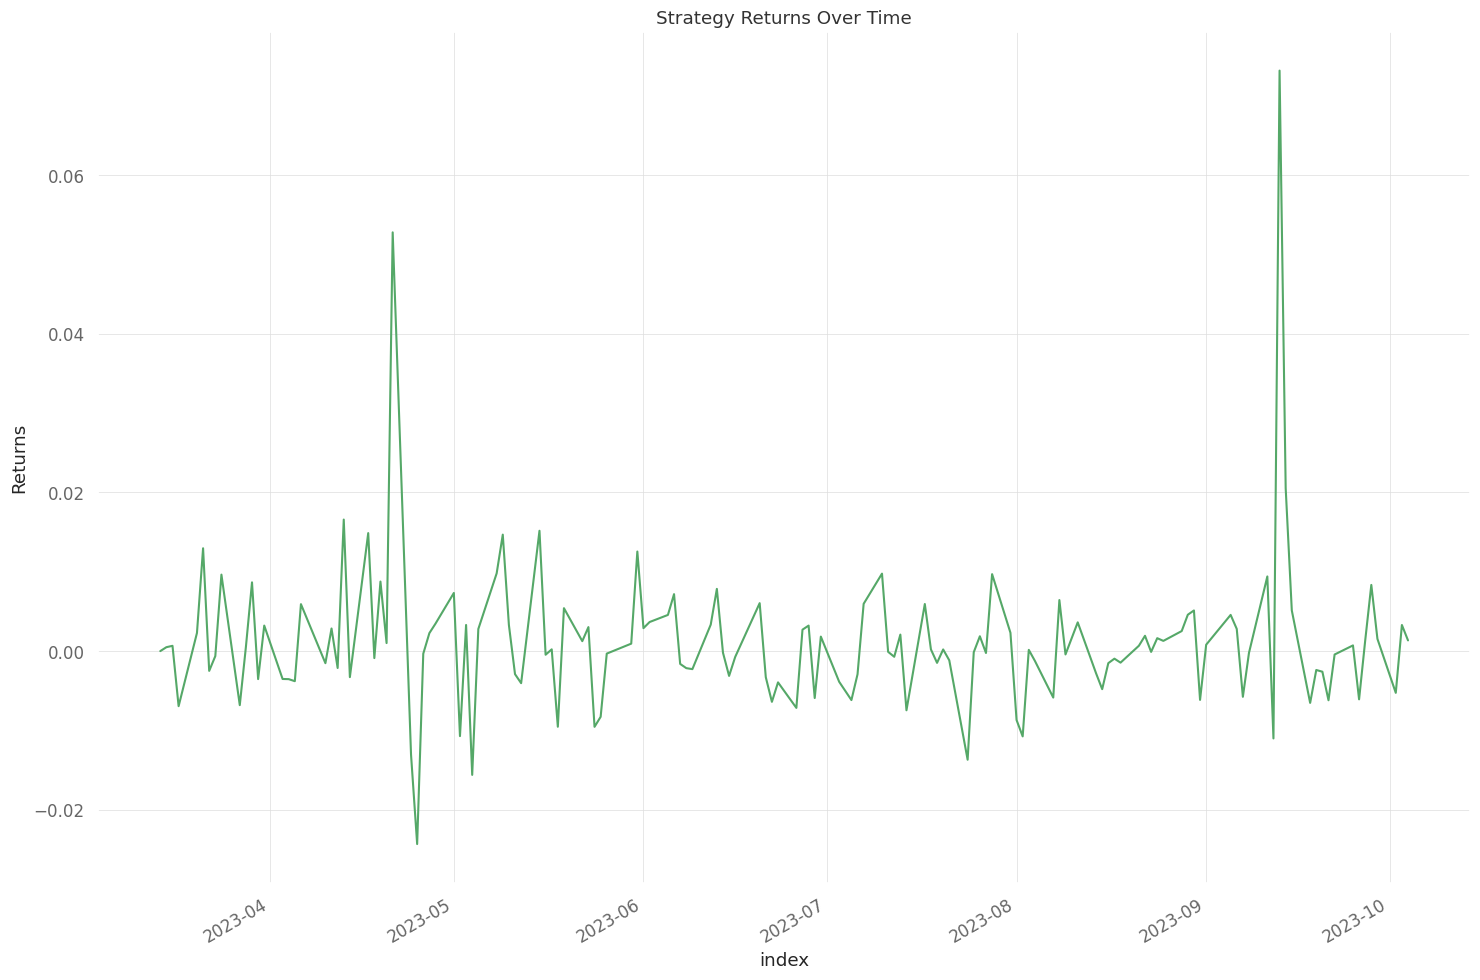

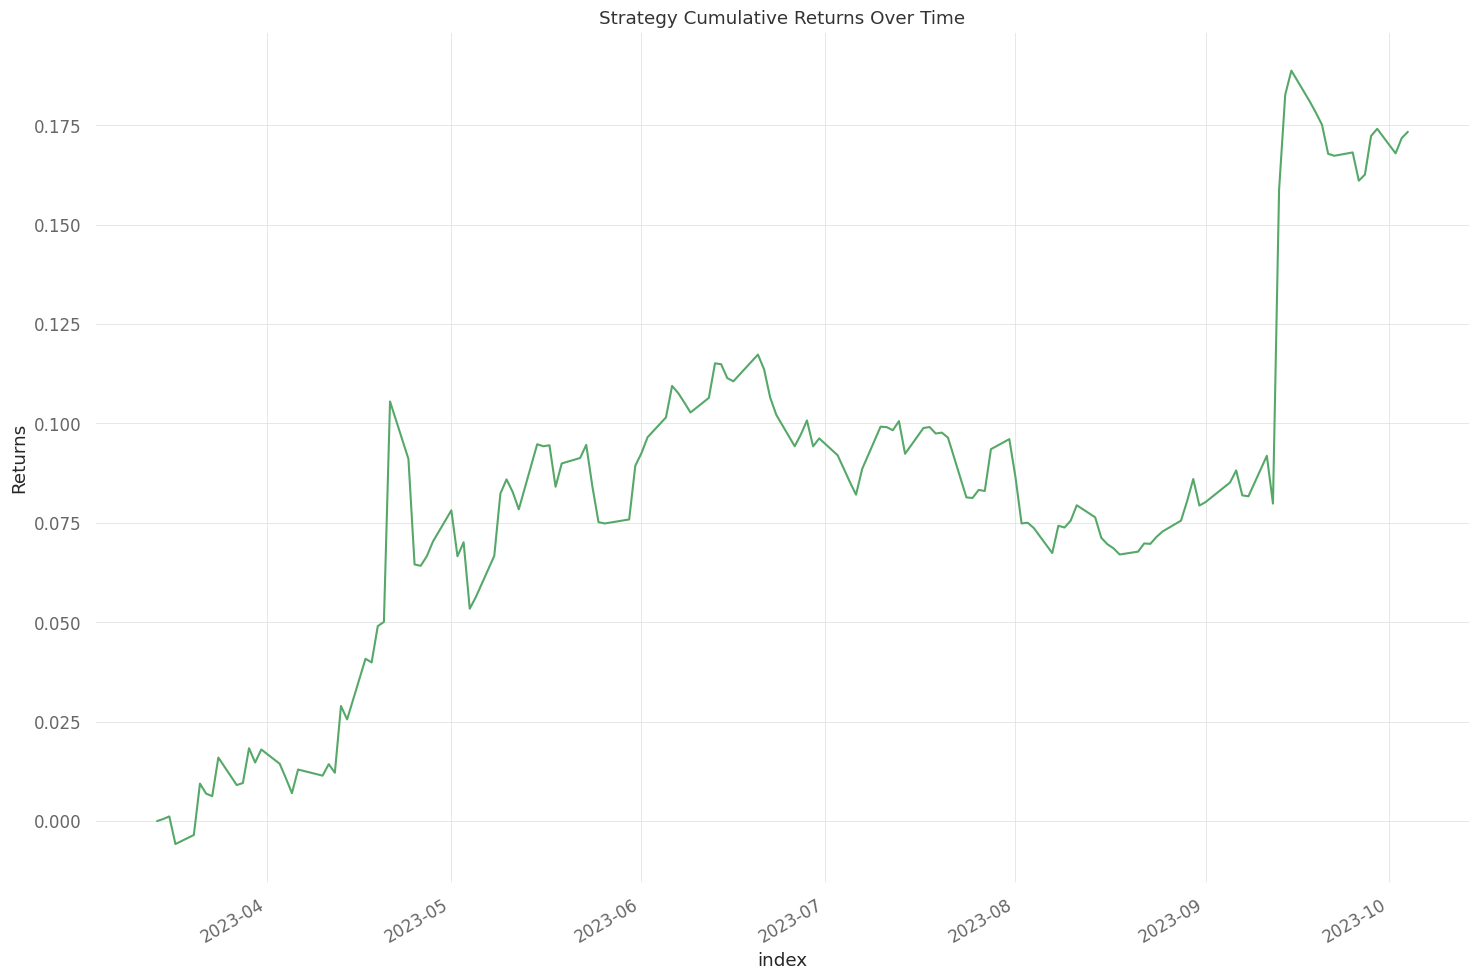

In [55]:
# Load and preprocess DataFrame


features = ['momentum',
            'impl_volatility', 
             'put_call_ratio_delta_0_25', 
             'open_interest_ratio_delta_0_25',
             'log_volume_short_term_c',
             'delta_change_norm_short_term_c',
             'log_volume_mid_term_c',
             'unusual_volume_mid_term_c',
             'delta_change_norm_mid_term_c',
             'log_volume_long_term_c',
             'unusual_volume_long_term_c']

#features = ['momentum']


# features = ['momentum', 'volatility', 
#         'put_call_ratio_delta_0_25',
#         'open_interest_ratio_delta_0_25', 
#         'impl_volatility']

df = prepare_features(df_stack)

# Replace dots with underscores in column names
df.columns = [col.replace('.', '_') for col in df.columns]

# Run backtest  df[df['permno'].isin([15436, 10200, 15847, 15936, 15937, 16062, 16260])]
models, test_results, stats, meta = main(df, features, MultiStockStrategy, MultiStockData, verbose=False)

# issue: backtrader is skipping days for some reason, something do with prenext getting called for no reason

In [49]:
import pickle as pkl

with open('strat_data_better.pkl', 'wb') as f:
    pkl.dump(meta, f)


In [50]:
with open('strat_data_better.pkl', 'rb') as f:
    meta2 = pkl.load(f)

In [63]:
meta[0][0]

index
2023-03-14 00:00:00+00:00    0.000000
2023-03-15 00:00:00+00:00    0.000551
2023-03-16 00:00:00+00:00   -0.001037
2023-03-17 00:00:00+00:00   -0.005710
2023-03-20 00:00:00+00:00    0.004215
                               ...   
2023-09-28 00:00:00+00:00   -0.000942
2023-09-29 00:00:00+00:00   -0.000652
2023-10-02 00:00:00+00:00   -0.000656
2023-10-03 00:00:00+00:00    0.003264
2023-10-04 00:00:00+00:00    0.003814
Name: return, Length: 142, dtype: float64

In [74]:
pd.DataFrame(meta[0][0]).to_csv('strat_better_returns_trailing_stop.csv')

In [48]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  
    print(df[df['permno'].isin(tickers_with_data)].groupby('date').count())

            permno  cusip  bid  ask  vol  ...  price_ma50  rsi  momentum  \
date                                      ...                              
2020-03-13     225    225  225  225  225  ...         225  225       225   
2020-03-16     225    225  225  225  225  ...         225  225       225   
2020-03-17     227    227  227  227  227  ...         227  227       227   
2020-03-18     221    221  221  221  221  ...         221  221       221   
2020-03-19     226    226  226  226  226  ...         226  226       226   
...            ...    ...  ...  ...  ...  ...         ...  ...       ...   
2023-12-22     277    277  277  277  277  ...         277  277       277   
2023-12-26     276    276  276  276  276  ...         276  276       276   
2023-12-27     279    279  279  279  279  ...         279  279       279   
2023-12-28     281    281  281  281  281  ...         281  281       281   
2023-12-29     279    279  279  279  279  ...         279  279       279   

           

In [69]:
(meta[0][0] + 1).cumprod()

index
2023-03-14 00:00:00+00:00    1.000000
2023-03-15 00:00:00+00:00    1.000551
2023-03-16 00:00:00+00:00    0.999513
2023-03-17 00:00:00+00:00    0.993806
2023-03-20 00:00:00+00:00    0.997994
                               ...   
2023-09-28 00:00:00+00:00    1.144034
2023-09-29 00:00:00+00:00    1.143288
2023-10-02 00:00:00+00:00    1.142538
2023-10-03 00:00:00+00:00    1.146267
2023-10-04 00:00:00+00:00    1.150639
Name: return, Length: 142, dtype: float64

In [ ]:
datetime.datetime.strptime(args.fromdate, '%Y-%m-%d')

In [35]:
 test_results.datas[0].params.min

# TODO

in backtester.py need to make "features" a passed variable so that the trainer and the checker can work with different strategies 

figure out how to make a dynamic data feed class to which we can pass the lines and mappings we want and have it just do its automatically